In [1]:
#!/usr/bin/python
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy import stats
import math
import tensorflow as tf
np.random.seed(1)
tf.set_random_seed(1)
from sklearn.feature_extraction.image import extract_patches_2d as ep2
import timeit

import os, sys
import csv
# Open a file
def read_datafile(file_name):
    data = np.loadtxt(file_name, delimiter=',', skiprows=10)
    return data

In [2]:
def Line_Plot(y):
    x=range(len(y))
    fig, ax = plt.subplots()
    ax.plot(x, y)
#     fig.set_size_inches(18, 10)
    plt.show()
# plotting collected dataset
#loads files as 'data'

In [3]:
path = "/Users/jacksonkrauss/Desktop/Jupyter/Trial3/Walk/"
dirs = os.listdir( path )

In [4]:
# This would print all the files and directories
D1 = np.zeros((1000*6,3))
D2 = np.zeros((1000*6,3))
D3 = np.zeros((1000*6,3))

In [5]:
dir1 = iter(dirs)
#next(dir1)
i = 0
j = 1
k1 = 0
k2 = 0
k3 =0
for file in dir1:
    #print(file)
    data = read_datafile(path + file)
    midpoint = math.floor(len(data)/2)
    if j%3 == 1:
        D1[(k1)*1000:(k1+1)*1000,:]=data[midpoint-500:midpoint+500,1:4]
        k1+=1
    elif j%3 ==2:
        D2[(k2)*1000:(k2+1)*1000,:]=data[midpoint-500:midpoint+500,1:4]
        k2+=1
    elif j%3 ==0:
        D3[(k3)*1000:(k3+1)*1000,:]=data[midpoint-500:midpoint+500,1:4]
        k3+=1
    i+=1
    j+=1
    #print(i)
    #print(j)
    

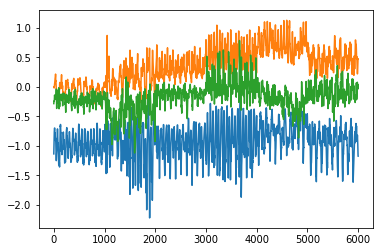

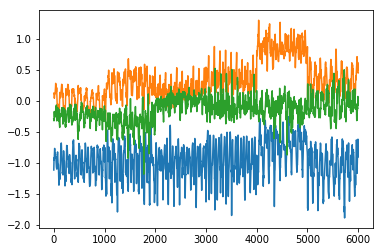

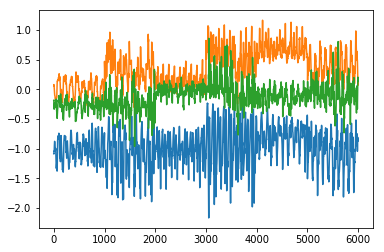

In [6]:
Line_Plot(D1)
Line_Plot(D2)
Line_Plot(D3)

In [7]:
X_Train = D2
X_Test = D1
X_Train2 = D3
X_Train3 = D1

In [8]:
k=np.ones((1000,))

In [9]:
Y_Train = np.concatenate((0*k,1*k,2*k,3*k,4*k,5*k)).astype(int)
Y_Train2 = np.concatenate((0*k,1*k,2*k,3*k,4*k,5*k)).astype(int)
Y_Train3 = np.concatenate((0*k,1*k,2*k,3*k,4*k,5*k)).astype(int)
Y_Test = Y_Train.astype(int)

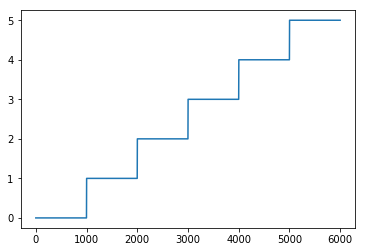

In [10]:
Line_Plot(Y_Train)

In [11]:
Y_Test=Y_Test[:,None]
Y_Train=Y_Train[:,None]
Y_Train2=Y_Train2[:,None]
Y_Train3=Y_Train3[:,None]

In [12]:
print(X_Test.shape)
print(X_Train.shape)
print(X_Train2.shape)
print(Y_Test.shape)
print(Y_Train.shape)
print(Y_Train2.shape)

(6000, 3)
(6000, 3)
(6000, 3)
(6000, 1)
(6000, 1)
(6000, 1)


In [13]:
N = 5 # Size of N-gram time window
D = 500 # Dimension of Hypervectors
Levels=40  # Number of levels for digitization
Threshold = 0.8
CH=3 # Amount of channels

In [14]:
def Create_Hypervector(D):
    randomIndex = np.random.permutation(D)
    randomHV = np.zeros((D,))
    randomHV[randomIndex[0 : int(D/2)]] = 1
    randomHV[randomIndex[int(D/2)+1 : D]] = -1
    return randomHV

In [15]:
def Compute_Ngram(data, CiM, iM):

    Ngram = np.ones((1,iM.shape[1]))
    
    for time in range(data.shape[0]):
        
        record = np.zeros((1,iM.shape[1]))
        
        for channel in range(data.shape[1]):
            
            record += CiM[data[time,channel],:] * iM[channel,:]
            
        Ngram = np.roll(Ngram,1) * record
        
    return Ngram

In [16]:
def Cosine_Similarity(u, v):
  
    u = np.matrix(u)
    v = np.matrix(v)
    c = np.divide(np.matmul(u,np.transpose(v)),np.spacing(1)+np.sqrt(np.sum(np.multiply(u,u),axis=1))*np.sqrt(np.sum(np.multiply(v,v),axis=1)))
    
    return c

In [17]:
def HDC_Train(Y, X, CiM, iM, N, Threshold, AM=False):
    
    if AM is False:
        AM = np.zeros((np.max(Y)+1,iM.shape[1]))

    for i in range(X.shape[0]-(N+1)):

        Ngram = Compute_Ngram(X[i:i+N-1,:], CiM, iM)
      
        Angle = Cosine_Similarity(Ngram, AM[Y[i+N-1],:])
        
        if Angle < Threshold or np.isnan(Angle):

            AM[Y[i+N-1],:] += Ngram
        
    AM/=norm(AM,2)
        
    return AM

In [18]:
def HDC_Predict (Y, X, AM, CiM, iM, N):

    Correct = 0
    Count = 0
    
    for i in range(len(Y)-(N+1)):

        Label = stats.mode(Y[i:i+N-1], axis=None)[0][0]
    
        Signal_HV = Compute_Ngram(X[i:i+N-1,:], CiM, iM)   
        
        Guess=np.argmax(Cosine_Similarity(AM, Signal_HV))
        
        if Guess == Label:
            Correct += 1
        
        Count += 1
        Accuracy = Correct / float(Count)
        
    return Accuracy

In [19]:
def Continuous_Item_Memory(D, MAXL):
    
    CiM = np.zeros((MAXL,D)) #create empty memory
    
    HV = Create_Hypervector(D)
    r = np.random.permutation(D)
    
    for i in range(MAXL):
        
        CiM[i,:] = HV
        #50 bits away from each until they become orthogonal
        SP = np.floor(D/2/MAXL)
        start = int((i*SP) + 1)
        end = int(((i+1)*SP) + 1)
        HV[r[start:end]] = HV[r[start:end]]*-1 #flips bits
        
    return (CiM)

In [20]:
def Item_Memory(D, CH):
    
    iM = np.zeros((CH,D)) #item memory orthogonal direction
    
    for row in range(CH):
        
        iM[row,:] = Create_Hypervector(D)
    
    return (iM)

In [21]:
def Make_Integer(x,count):

    start = np.min(x)
    stop = np.max(x)
    bins = np.linspace(start, stop, count-1)
    x = np.digitize(x, bins)
    
    return x

In [22]:
X_Train = Make_Integer(X_Train,Levels)
X_Train2 = Make_Integer(X_Train2,Levels)
X_Train3 = Make_Integer(X_Train3,Levels)
X_Test = Make_Integer(X_Test,Levels)

In [23]:
print(X_Train.shape)

(6000, 3)


In [24]:
iM = Item_Memory(D, CH)

In [25]:
CiM = Continuous_Item_Memory(D, Levels)

In [26]:
model_1 = HDC_Train(Y_Train, X_Train, CiM, iM, N, Threshold)

In [27]:
accuracy = HDC_Predict(Y_Test, X_Test, model_1, CiM, iM, N)

In [28]:
accuracy

0.3033033033033033

In [29]:
model_2 = HDC_Train(Y_Train2, X_Train2, CiM, iM, N, Threshold, model_1)

In [30]:
accuracy2 = HDC_Predict(Y_Test, X_Test, model_2, CiM, iM, N)

In [31]:
accuracy2

0.5729062395729062

In [32]:
model_3 = HDC_Train(Y_Train3, X_Train3, CiM, iM, N, Threshold, model_2)

In [33]:
accuracy3 = HDC_Predict(Y_Test, X_Test, model_3, CiM, iM, N)

In [34]:
accuracy3

0.5999332665999333